# Tunable Scrambling Circuit

Reference: Verified Quantum Information Scrambling https://arxiv.org/abs/1806.02807

![paper](./pics/Telpo1_Tunable_Scrambling_Circ.jpg)

![experiment](./pics/Telpo2_Tunable_Scrambling_Circ.jpg)

Tunable Circ:

![tunable](./pics/Telpo3_Tunable_Scrambling_Circ.jpg)

From Scrambling Library
![tunablegrover](./pics/Tunable_Scrambling_Grover_Circ.jpg)

# Implementation

To make this protocol more hardware efficient, we adapted the method depicted above. Instead of XX Gates, we are using CZ gates as entangling gates. The alpha parameter to tune the scrambling now can be chosen between -1 for no scrambling or zero percent teleportation fidelity, and +1 for full scrambling and teleporation fidelity. When alpha is set to zero, a 50% fidelity is expected.

In [1]:
# general imports:
%matplotlib inline
import matplotlib, qiskit, pprint, itertools
from matplotlib import pyplot as plt
import numpy as np
from numpy import pi
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, IBMQ, transpile, schedule, assemble
from qiskit.circuit import *
from qiskit.circuit.library.standard_gates import *
from qiskit.providers.aer import QasmSimulator
from qiskit.test.mock import FakeAlmaden, FakeMelbourne
from qiskit.visualization import *
from qiskit.circuit.library import *

In [2]:
# import utils for Quantum Information Scrambling Verification Test:
from QSVT_utils import *

In [3]:
# load account:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

# get simulators:
f_alma = FakeAlmaden() # simulator f_alma for pulse schedules
f_mel = FakeMelbourne() # simulator f_mel for simulator backend mel
qasm_simulator = Aer.get_backend('qasm_simulator') 

# Step 1: Preparations


Before we go ahead and make our actual tunable scrambling circuit, we are going to prepare ourselfs some handy lists and variables to store qubit indexnumbers based on the number of qubits we set $n$ as the size of the scrambling unitary we'd like to use. 

For this example, let's set $n = 3$:

In [9]:
#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits scrambling unitary operates on
n = 3

In the QSVT_utils module you can find some functions to return you lists with the qubit indexnumbers that will be used for one-qubit gates and nested list containing the indexnumbers of qubits pairs, the two-qubit gates will be applied to in the scrambling process.

Of course, you can define your own lists instead, for example, if you'd like to use a specific transpiler, mapping, or simply want to mess around a little bit and insert your very personal chaos into your experimental setup 😉

We are going to run our demonstration experiments on the QasmSimulator, and just go ahead with the list and variables we will get just by running this cell without any adjustments:

In [10]:
# num of qubits in circuit (must be twice the size of the scrambling unitery size n plus one extra qubit for bob) 
qnum = 2*n +1

# lists with inums of upper and lower half qubits (will be used for one q gates in the scrambler)
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# nested list with inums of bell pair defining the many-body-system 
bell_pairs = get_bell_pairs(qnum)

# nested lists with inums of all bell pairs, that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# get pairs for two-qubit gates in scrambling protocol
upper_pairs, lower_pairs = get_unitary_pairs(qnum)

# alice gets qubit inum 0, bob gets the qubit with highest inum 
inum_alice, inum_bob = 0, qnum-1

Awesome! Now there is just one last variable we are going the define before initializing our circuit. That's the bell pair we'd like to use for the last step in the protocol: bell measurement and conditional decoding.

Here, we'll go with the bell pairs having the indexnumbers furthes away from the indexnumbers we defined for Alice and Bob. To get them, we can just take the first item of the nested list called meas_pairs (because the structuring functions in QSVT_utils follow a layering procedure starting with medial indexnumbers of the "Butterfly" EPR pair).

Any of the EPR pair should give you the very same results though (amongs other things, that fact also provides you with some handy options for quick sanity checks of your own indexnumber variables and lists by the way, e.g. if you choose to hand code them).

In [11]:
# variable qubit pair that will be used for base measurement (any pair will do)
# here: fist pair in the list is the middle pair (furthes away from bob and alice)
basemeas = meas_pairs[0]

Now we are done with the preparations and get rolling with our first tuned scrambling experiment!

## Experiment A: $\alpha = +1$

We will start with $\alpha = +1$, expecting to get 100% teleportation fidelity. All we need to do, is define this tuning parameter as such:

In [12]:
# set the desired fidelity (1 means 100% teleportation fidelity)
alpha = 1

Tuning the scrambling properties, actually means, we are going to detune the angles of the one qubits gates in the transposed scrambler (e.g. on the qubits with indexnumbers previously stored in the list called sec_half) from the remaining ones.

A perfect fidelity is expected, with all the angles $\theta$ within our scrambler are set to: 

$$
\theta = \frac{\pi}{2}
$$


Where the general equation reads:

$$
\theta = \frac{\alpha \pi}{2}
$$

A function to return us the angles based on the alpha we pass it, is also implemented in QSVT_utils, so all we need to do is run the following cell:

In [13]:
# we need to different thetas in order to programm detuning, 
# here theta will be the angle corresponding to full fidelity alpha=1, 
# beta will be the detuned version of theta, corresponding on the alpha value we defined

theta = get_theta_from_alpha(1) 
beta = get_theta_from_alpha(alpha)

Finally! Here comes the circuit! Because we already defined everything we need, we now can just run this cell with all the steps needed to setup the circuit for our experiment. Nice! Let's do it and see what our circuit looks like!

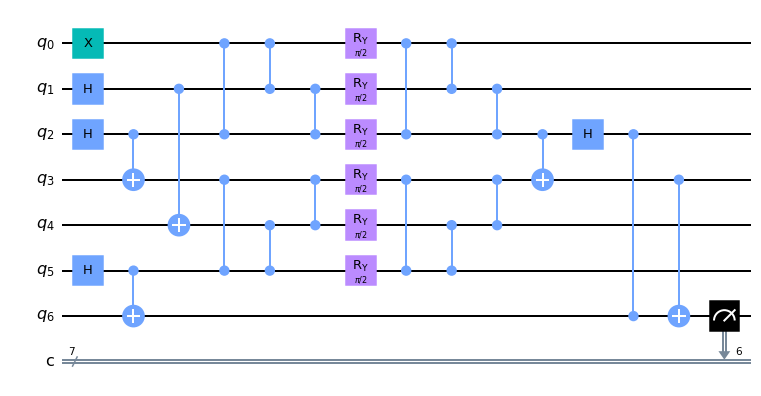

In [16]:
#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

circ = QuantumCircuit(qnum,qnum) # initialize circ 

circ.x(inum_alice) # initialize alice qubit in |1> state

entangle_bell_pairs(circ, bell_pairs) # initialize bell pairs

###################################### STEP 2: TUNABLE SCRAMBLING PROTOCOL
#############################################################################################

for pair in upper_pairs:
    circ.cz(pair[0],pair[1])
    
for pair in lower_pairs:
    circ.cz(pair[0],pair[1])
    
circ.barrier()

for q in fst_half:
    circ.ry(theta,q)
    
for q in sec_half:
    circ.ry(beta,q)

for pair in upper_pairs:
    circ.cz(pair[0],pair[1])
    
for pair in lower_pairs:
    circ.cz(pair[0],pair[1])
circ.barrier()
 
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

disentangle_bell_pair(circ, basemeas) # disentangle base meas bell pair

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

apply_bob_gates(circ,inum_bob,basemeas) # apply decoding from measurement

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

circ.measure(inum_bob,inum_bob) # measure bob qubit

#############################################################################################

circ.draw('mpl', plot_barriers=False) # see circ

Here we see the complete experimental setup. Our hardware efficient implementation only deals with CZ and Ry gates in the scrambler. The first H and CX gates of course are our initial EPR pair entanglements. The X on q0 is just there for demonstration reasons, and the last four sets CX, H, CZ, CX are the EPR measurement, the teleportation decoding of Bob and finaly the measurement on Bob's qubit.

Let's run it and see if the fidelity really corresponds the expected 100% teleportation fidelity!


 Fidelity Bob Qubit:   	 100.0%


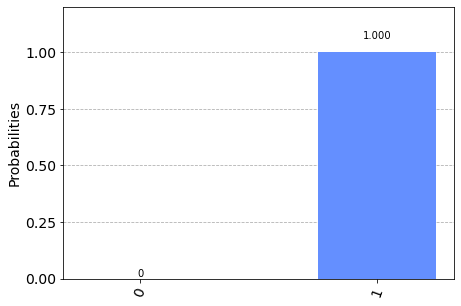

In [17]:
###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit:   \t {}%".format(100*round(bob_1/(bob_1+bob_0),3)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

**Perfect! Just as we expected!**

Now let's test some more different alpha values and see how the fidelity turns out. 

# Experiment B: alpha = -1

In [19]:
# set the desired fidelity (-1 means 0% teleportation fidelity)
alpha = -1


 Fidelity Bob Qubit:   	 0.0%


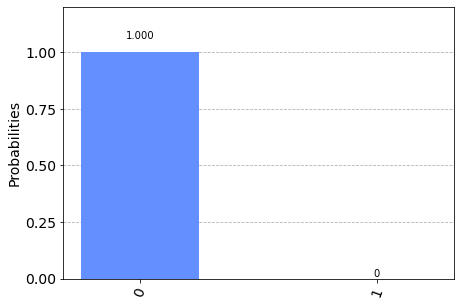

In [20]:
#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

# get the corresponding angles for alpha value: 

theta = get_theta_from_alpha(1)
beta = get_theta_from_alpha(alpha)

###################################### STEP 1: PREPARATIONS
#############################################################################################

circ = QuantumCircuit(qnum,qnum) # initialize circ 

circ.x(inum_alice) # initialize alice qubit in |1> state

entangle_bell_pairs(circ, bell_pairs) # initialize bell pairs

###################################### STEP 2: TUNABLE SCRAMBLING PROTOCOL
#############################################################################################

for pair in upper_pairs:
    circ.cz(pair[0],pair[1])
    
for pair in lower_pairs:
    circ.cz(pair[0],pair[1])
    
circ.barrier()

for q in fst_half:
    circ.ry(theta,q)
    
for q in sec_half:
    circ.ry(beta,q)

for pair in upper_pairs:
    circ.cz(pair[0],pair[1])
    
for pair in lower_pairs:
    circ.cz(pair[0],pair[1])
circ.barrier()
 
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

disentangle_bell_pair(circ, basemeas) # disentangle base meas bell pair

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

apply_bob_gates(circ,inum_bob,basemeas) # apply decoding from measurement

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

circ.measure(inum_bob,inum_bob) # measure bob qubit

#############################################################################################

#circ.draw('mpl') # see circ

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit:   \t {}%".format(100*round(bob_1/(bob_1+bob_0),3)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

# Experiment C: alpha = 0

In [21]:
# set the desired fidelity (0 means 50% teleportation fidelity)
alpha = 0


 Fidelity Bob Qubit:   	 47.699999999999996%


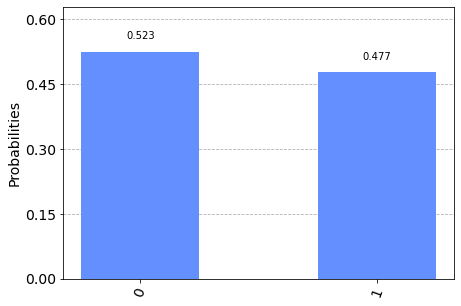

In [22]:
#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

# get the corresponding angles for alpha value: 

theta = get_theta_from_alpha(1)
beta = get_theta_from_alpha(alpha)

###################################### STEP 1: PREPARATIONS
#############################################################################################

circ = QuantumCircuit(qnum,qnum) # initialize circ 

circ.x(inum_alice) # initialize alice qubit in |1> state

entangle_bell_pairs(circ, bell_pairs) # initialize bell pairs

###################################### STEP 2: TUNABLE SCRAMBLING PROTOCOL
#############################################################################################

for pair in upper_pairs:
    circ.cz(pair[0],pair[1])
    
for pair in lower_pairs:
    circ.cz(pair[0],pair[1])
    
circ.barrier()

for q in fst_half:
    circ.ry(theta,q)
    
for q in sec_half:
    circ.ry(beta,q)

for pair in upper_pairs:
    circ.cz(pair[0],pair[1])
    
for pair in lower_pairs:
    circ.cz(pair[0],pair[1])
circ.barrier()
 
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

disentangle_bell_pair(circ, basemeas) # disentangle base meas bell pair

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

apply_bob_gates(circ,inum_bob,basemeas) # apply decoding from measurement

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

circ.measure(inum_bob,inum_bob) # measure bob qubit

#############################################################################################

#circ.draw('mpl') # see circ

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit:   \t {}%".format(100*round(bob_1/(bob_1+bob_0),3)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

# Experiment D: alpha = 0.25

Let's also pick some arbitrary alpha value. For example 0.25:

In [42]:
# set the desired fidelity 
alpha = 0.25


 Fidelity Bob Qubit:   	 70.1%


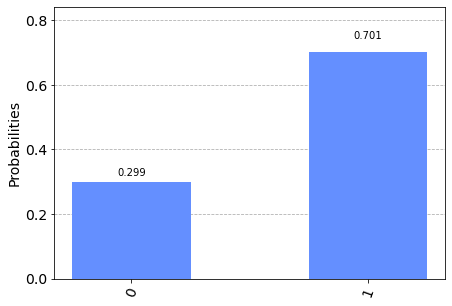

In [44]:
#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

# get the corresponding angles for alpha value: 

theta = get_theta_from_alpha(1)
beta = get_theta_from_alpha(alpha)

###################################### STEP 1: PREPARATIONS
#############################################################################################

circ = QuantumCircuit(qnum,qnum) # initialize circ 

circ.x(inum_alice) # initialize alice qubit in |1> state

entangle_bell_pairs(circ, bell_pairs) # initialize bell pairs

###################################### STEP 2: TUNABLE SCRAMBLING PROTOCOL
#############################################################################################

for pair in upper_pairs:
    circ.cz(pair[0],pair[1])
    
for pair in lower_pairs:
    circ.cz(pair[0],pair[1])
    
circ.barrier()

for q in fst_half:
    circ.ry(theta,q)
    
for q in sec_half:
    circ.ry(beta,q)

for pair in upper_pairs:
    circ.cz(pair[0],pair[1])
    
for pair in lower_pairs:
    circ.cz(pair[0],pair[1])
circ.barrier()
 
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

disentangle_bell_pair(circ, basemeas) # disentangle base meas bell pair

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

apply_bob_gates(circ,inum_bob,basemeas) # apply decoding from measurement

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

circ.measure(inum_bob,inum_bob) # measure bob qubit

#############################################################################################

#circ.draw('mpl') # see circ

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit:   \t {}%".format(100*round(bob_1/(bob_1+bob_0),3)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)